
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to  Moodle. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):

    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)

    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)

    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!

        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)

    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)

    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")

def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        num_neurons = np.prod(s[1:])  # Calculate the number of neurons excluding the batch dimension
        print(f"Layer {idx}: {num_neurons} neurons / {s}")
        #print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features


## Circle generator


In [ ]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


In [ ]:
#TASK 1: AUTOENCODER, 9 NEURONS, ~ 1 min 30 secs runtime

# DEFINE NETWORK
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(27, 27, 1)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),

    # Flatten and go through the Bottleneck
    layers.Flatten(),
    layers.Dense(9, activation='relu'),  # Bottleneck with 9 neurons

    # Decoder with Convolutional Layers
    layers.Dense(7 * 7 * 16, activation='relu'),  # Adjusted size to fit the convolutional structure
    layers.Reshape((7, 7, 16)),
    layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='valid'),  # Upsample to [15, 15, 16]
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='valid'),  # Upsample to [31, 31, 32]
    layers.Cropping2D(cropping=((2, 2), (2, 2))),  # Crop to [27, 27, 32]
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # Final output layer
])

#COMPILE AND TRAIN MODEL
model.compile(loss='mean_squared_error',
              optimizer='adam')

steps=3000
cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=10,steps=steps)


model.summary()

#COST FUNCTION
final_cost = cost[-1]
print(f"The final training cost is: {final_cost}")



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 1)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 flatten_4 (Flatten)         (None, 3136)              0         
                                                                 
 dense_8 (Dense)             (None, 9)                 28233     
                                                                 
 dense_9 (Dense)             (None, 784)               7840      
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 16)          0         
                                                      

In [ ]:
#improving model performance with a function, ~ 1 min

def prune_weights(model, threshold=0.01):
    '''Prunes weights in the specified model by setting values below a threshold to zero. Removes neurons that don't do anything - improves performance of our model

    Parameters:
        model (keras.models.Sequential): The model whose weights are to be pruned.
        threshold (float): The threshold below which weights are set to zero. Default is 0.01.

    Returns:
        keras.models.Sequential: The pruned model with updated weights.
         '''
    for layer in model.layers:
        if isinstance(layer, layers.Dense) or isinstance(layer, layers.Conv2D):
            weights, biases = layer.get_weights()
            pruned_weights = np.where(np.abs(weights) < threshold, 0, weights)
            layer.set_weights([pruned_weights, biases])
    return model


# Then, prune the model
pruned_model_og = prune_weights(model)

pruned_model_og.compile(optimizer='adam', loss='mean_squared_error')

##Retrain the Pruned Model
pruned_cost_array_og, y_target_pruned_og = generate_and_train(pruned_model_og, circle_generator, 27, batchsize=1000, steps=30)

# To check the final cost after training:
final_cost_pruned_og = pruned_cost_array_og[-1]
print(f"The pruned final training cost is: {final_cost_pruned_og}")

The pruned final training cost is: 0.007045758422464132


Layer 0: 196 neurons / (10, 14, 14, 1)
Layer 1: 3136 neurons / (10, 14, 14, 16)
Layer 2: 3136 neurons / (10, 3136)
Layer 3: 3 neurons / (10, 3)
Layer 4: 784 neurons / (10, 784)
Layer 5: 784 neurons / (10, 7, 7, 16)
Layer 6: 3600 neurons / (10, 15, 15, 16)
Layer 7: 29662 neurons / (10, 31, 31, 32)
Layer 8: 23328 neurons / (10, 27, 27, 32)
Layer 9: 729 neurons / (10, 27, 27, 1)


Text(0.5, 1.0, 'Autoencoder (9 neurons)')

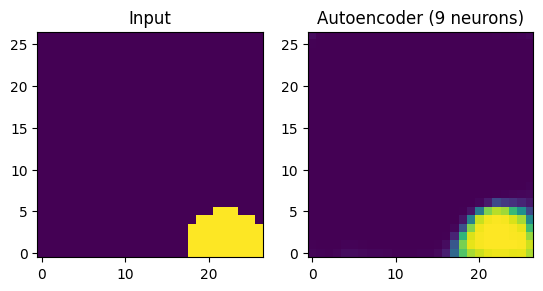

In [ ]:
#print_layers() to see no. of neurons per layer
print_layers(model, y_target)

#check generated circle vs output of autoencoder (9 neuron bottleneck)
plot_test_image(pruned_model_og, circle_generator, 27)
plt.title('Autoencoder (9 neurons)')

In [ ]:
#TASK 2: AUTOENCODER, 3 NEURONS, ~ 3 min

# DEFINE NETWORK
model1 = models.Sequential([
    layers.Input(shape=(27, 27, 1)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),

    # Flatten and go through the Bottleneck
    layers.Flatten(),
    layers.Dense(3, activation='relu'),  # Bottleneck with 3 neurons

    # Decoder with Convolutional Layers
    layers.Dense(7 * 7 * 16, activation='relu'),  # Adjusted size to fit the convolutional structure
    layers.Reshape((7, 7, 16)),
    layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='valid'),  # Upsample to [15, 15, 16]
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='valid'),  # Upsample to [31, 31, 32]
    layers.Cropping2D(cropping=((2, 2), (2, 2))),  # Crop to [27, 27, 32]
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # Final output layer
])

#COMPILE AND TRAIN MODEL
model1.compile(loss='mean_squared_error',
              optimizer='adam')

steps_new=3000
cost_array,y_target_new =generate_and_train(model1,circle_generator,img_size=9*3,batchsize=10,steps=steps_new)


model1.summary()


#COST FUNCTION
final_cost_new = cost_array[-1]
print(f"The final training cost is: {final_cost_new}")


# Then, prune the model
pruned_model = prune_weights(model1)

pruned_model.compile(optimizer='adam', loss='mean_squared_error')

##Retrain the Pruned Model
pruned_cost_array, y_target_pruned = generate_and_train(pruned_model, circle_generator, 27, batchsize=10, steps=steps_new)

# To check the final cost after training:
final_cost_pruned = pruned_cost_array[-1]
print(f"The pruned final training cost is: {final_cost_pruned}")



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 1)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 flatten_7 (Flatten)         (None, 3136)              0         
                                                                 
 dense_14 (Dense)            (None, 3)                 9411      
                                                                 
 dense_15 (Dense)            (None, 784)               3136      
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 16)          0         
                                                      

Layer 0: 196 neurons / (10, 14, 14, 1)
Layer 1: 3136 neurons / (10, 14, 14, 16)
Layer 2: 3136 neurons / (10, 3136)
Layer 3: 3 neurons / (10, 3)
Layer 4: 784 neurons / (10, 784)
Layer 5: 784 neurons / (10, 7, 7, 16)
Layer 6: 3600 neurons / (10, 15, 15, 16)
Layer 7: 29662 neurons / (10, 31, 31, 32)
Layer 8: 23328 neurons / (10, 27, 27, 32)
Layer 9: 729 neurons / (10, 27, 27, 1)


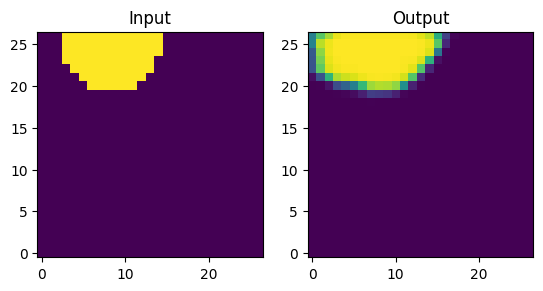

In [ ]:
#print_layers() to see no. of neurons per layer
print_layers(model1, y_target_new)

#check generated circle vs output of autoencoder (3 neuron bottleneck)
plot_test_image(pruned_model, circle_generator, 27)

###Conclusion

Model architecture:The inclusion of convolutional, pooling, dense, and transpose convolutional layers in the autoencoder architecture facilitates effective feature extraction, dimensionality reduction, and reconstruction of input images. The bottleneck layer serves as the compressed representation of the input data, capturing the key features of an image.


Bottleneck size:

In Task 1, the bottleneck with 9 neurons allowed us to strike a balance between retaining essential information for effective reconstruction while still managing computational complexity within reasonable bounds. However, Task 2's constraint of a bottleneck with only 3 neurons posed a more significant challenge, as it required more aggressive compression, leading to a pronounced trade-off between preserving critical details and maintaining computational efficiency.

Training performance:

We observed notable differences between the two architectures. For the network with a 9-neuron bottleneck, we achieved a final training cost of 0.0094. After pruning, the cost further decreased to 0.0070, indicating successful convergence with minimal redundancy. Conversely, the network with a 3-neuron bottleneck presented greater challenges, with a final training cost of 0.0113, reflecting a more constrained architecture that struggled to capture essential features. Despite pruning, the cost remained relatively high at 0.0107, suggesting potential issues with underfitting due to excessive compression.

Pruning involved removing insignificant weights from the model, aiming to reduce redundancy and improve efficiency. While pruning helped marginally lower the final training cost, it failed to address the fundamental challenge of representing complex data with a constrained bottleneck. This underscores the limitations of pruning alone in improving performance and emphasises the need for a well-designed architecture from the outset. This illustrates the delicate tradeoff between model capacity and its ability to capture essential features, emphasising the need for careful consideration of architecture design to achieve optimal performance.

Generalisation:

Due to it’s higher cost function, the 9-neuron bottleneck model offers a higher capacity to capture intricate features present in the randomly generated circles due to its larger bottleneck size. With more neurons available in the bottleneck layer, the model can encode and decode a richer representation of the input data, potentially resulting in a more faithful reconstruction of the circles during training. This enhanced capacity allows the model to better generalise to unseen data by effectively capturing the underlying patterns and variations present in the circle images, leading to improved performance in terms of reconstruction accuracy and final training cost.

Task specific:

The constraints posed by the circle generator function, requiring the reconstruction of 27x27 pixel images from randomly generated circles, influenced our network design choices significantly.

Additionally, we adjusted batch sizes and training steps to ensure compliance with the sample size constraint while aiming for optimal convergence. By adjusting the batch size to 10 and the number of training steps to 3000, I aimed to balance computational efficiency with effective learning. Experimenting with different multiples of batch size and training steps, ensuring the total sample size remains within the specified limit of 30,000, allowed for thorough exploration of the model's learning dynamics. This iterative approach enabled me to identify the configuration that yielded the lowest final training cost, indicating a more efficient use of the available data for training the autoencoder networks.

Future directions:

It's worth exploring alternative network architectures, such as deeper or more complex models, to potentially improve the autoencoder networks' performance.
Exploring deeper or more complex models involves increasing the number of layers and adjusting their width, aiming to capture intricate patterns in the data for improved performance. However, balancing model complexity with computational resources and the risk of overfitting is crucial, as deeper or more complex models may require extensive training and regularisation to prevent overfitting on limited datasets.

Additionally, experimenting with different regularisation techniques, such as dropout or batch normalisation, could help address any overfitting issues encountered during training.

Furthermore, investigating alternative loss functions (metrics other than the mean squared error) tailored to the specific task requirements might provide insights into further optimising the models. This could include perceptual loss for image reconstruction tasks or adversarial loss for generative tasks. By exploring and adapting loss functions to match the task requirements, one can potentially improve the model's ability to learn meaningful representations and generate more accurate outputs.
